In [12]:
from dsfunctions import forward_pass, forward_pass_nsteps, sample_windspeed, sample_winddirection, sample_geometry
from dsfunctions import plot_matrix, plot_matrix_ensemble, align_geoms, interpolate_geom, get_observation, plot_geometry
from dsfunctions import geom_to_vector, reproject_geom, validate_geom

import farsiteutils_v2 as futils
import datetime
import uuid

import numpy as np
from matplotlib import pyplot as plt

from shapely.geometry import Polygon, MultiPolygon
import pandas as pd
import geopandas as gpd

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from multiprocessing import Pool
import contextily as ctx


####################################################
####################################################
def calculate_rms_state(state1, state2):
    return ((state1 - state2)**2).mean()
def calculate_area_diff_state(state1, state2):
    geom1 = Polygon(zip(state1[::2], state1[1::2]))
    geom2 = Polygon(zip(state2[::2], state2[1::2]))
    
    return (geom1.union(geom2) - geom1.intersection(geom2)).area
def align_states(state_lst, vertex_count=None):
    if vertex_count is None:
        vertex_count = max(len(st) for st in state_lst)//2
    x0 = state_lst[0][::2]
    y0 = state_lst[0][1::2]
    x1 = state_lst[1][::2]
    y1 = state_lst[1][1::2]

    geom0 = Polygon(zip(x0,y0))
    geom1 = Polygon(zip(x1,y1))

    geom0, geom1 = align_geoms([geom0, geom1], vertex_count)
    x,y = geom0.exterior.coords.xy
    x0 = x.tolist()[:-1]
    y0 = y.tolist()[:-1]
    state0 = xy_to_state(x0, y0)
    
    x,y = geom1.exterior.coords.xy
    x1 = x.tolist()[:-1]
    y1 = y.tolist()[:-1]
    state1 = xy_to_state(x1, y1)

    return [state0, state1]



def xy_to_state(x, y):
    ret = []
    for i in range(len(x)):
        ret.append(x[i])
        ret.append(y[i])

    return np.array(ret).reshape((2*len(x),1))

def state_to_xy(state):
    return state[::2], state[1::2]

def sample_xy(x,y, rng):
    xs = rng.normal(x, scale=100)
    ys = rng.normal(y, scale=100)

    return xs,ys


def calculate(initialidx, 
              observeidx,
              windspeed, winddirection, 
              usr: futils.User):

    lcpidx = usr.db.dfLandscape.index[0]
    barrieridx = usr.db.dfBarrier.index[0]
    
    # Setup the input data
    inputData = {'description': 'Maria_2019',
                 'igniteidx'  : initialidx,
                 'compareidx' : observeidx,
                 'lcpidx'     : lcpidx,
                 'barrieridx' : barrieridx,

                 'windspeed': windspeed, 'winddirection': winddirection,
                 'relhumid': 90, 'temperature': 20}

    mainapi = usr.calculatePerimeters(inputData)
    mainapi.run_farsite()

def forward_pass_farsite(poly, params):
    '''
        params: take values: 'windspeed', 'winddirection' ,'dt' (dt is a datetime.timedelta object)
                              'description' (Maria2019, Bridge2021, River2021)
    '''
    # Parameters to run the simulation
    windspeed = params['windspeed']
    winddirection = params['winddirection']
    dt = params['dt']
    description = params['description']
    
    # Create handles for simulation
    fp = futils.FilePaths('/home/jovyan/data/')
    usr = futils.User(fp, description)

    initialidx = uuid.uuid4().hex
    fpath = f'/home/jovyan/farsite-devAPI/inputs/Reference/{description}_{initialidx}.shp'
    # Creating the shp file for simulation
    gpd.GeoDataFrame({'FID': [0], 'geometry':poly}, crs='EPSG:5070').to_file(fpath)
    
    usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation', 
                                                                                               fpath, datetime.datetime.now(),
                                                                                               description]
    
    observeidx = uuid.uuid4().hex
    # Add observationidx only to calculate the dt in the backend
    usr.db.dfObservation.loc[observeidx, 'datetime'] = usr.db.dfObservation.loc[initialidx, 'datetime'] + dt
    
    # Run simulation for dt from initialidx
    calculate(initialidx, observeidx, windspeed, winddirection, usr)

    # add simulation as the next initial point
    try:
        dfsim = usr.db.dfsimulation[(usr.db.dfsimulation['igniteidx'] == initialidx) & 
                                (usr.db.dfsimulation['compareidx'] == observeidx)]
    except KeyError as e:
        print(e)
        print(usr.db.dfsimulation)
        return None
    
    if len(dfsim) < 1:
        return None
    
    # assert(len(dfsim) == 1) , f'Length of dfsim = {len(dfsim)}'
    if len(dfsim) != 1:
        raise ValueError(f'Length of dfsim = {len(dfsim)}')

    usr.db.dfObservation.loc[dfsim.index[0], ['filetype', 'description']] = ['Observation', description]
    
    simpath = f'/home/jovyan/farsite-devAPI/inputs/Reference/{description}_{observeidx}.shp'
    dfgeom = gpd.read_file(dfsim['filepath'].iloc[0])['geometry']
    assert(len(dfgeom) == 1), f'dfgeom has size = {len(dfgeom)}'
    dfgeom = dfgeom[0]

    # Remove the generated files
    !rm /home/jovyan/farsite-devAPI/inputs/Reference/*
    
    return Polygon(dfgeom.coords)

(array([  34.,  322., 1454., 3863., 5648., 4633., 2173.,  586.,   78.,
           9.]),
 array([-361.15471277, -283.78779975, -206.42088673, -129.0539737 ,
         -51.68706068,   25.67985234,  103.04676536,  180.41367838,
         257.7805914 ,  335.14750442,  412.51441744]),
 <BarContainer object of 10 artists>)

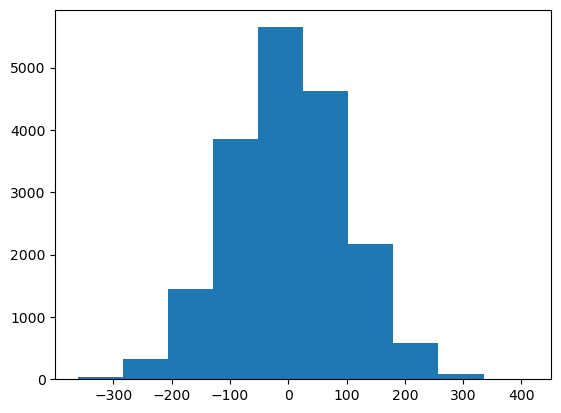

In [13]:
rng = np.random.Generator(np.random.PCG64(1234))

# Testing v_k

initial_state = geom_to_vector(get_observation('Maria2019', 0)[0])

nsamples = 100
state_ensemble = np.zeros((len(initial_state), nsamples))
for i in range(nsamples):
    state_ensemble[:,i:(i+1)] = xy_to_state(*sample_xy(initial_state[::2], initial_state[1::2], rng))

plt.hist((state_ensemble - state_ensemble.mean(axis=1, keepdims=True).repeat(nsamples, axis=1)).flatten())

In [14]:
# Testing w_k
winddirection = 90
wdsigma = 15
windspeed = 10
wssigma = 5
dt = datetime.timedelta(minutes=15)

sampled_wslst = []
sampled_wdlst = []
for s in range(nsamples):
    sampled_wslst.append(sample_windspeed(windspeed, wssigma, rng))
    sampled_wdlst.append(sample_winddirection(winddirection, wdsigma, rng))

zero_samples = []
xkhat_ensemble = np.zeros_like(state_ensemble)
zkphat_ensemble = np.zeros_like(state_ensemble)
for s in tqdm(range(nsamples)):

    xkhat_ensemble[:,s:(s+1)] = initial_state

    ws = sampled_wslst[s]
    wd = sampled_wdlst[s]

########################################
    forward_geom = forward_pass_farsite(Polygon(zip(xkhat_ensemble[:,s:(s+1)][::2], xkhat_ensemble[:,s:(s+1)][1::2])),
                                        {'windspeed': int(ws),
                                         'winddirection': int(wd),
                                         'dt': dt,
                                         'description': 'Maria2019'})
    if forward_geom is None:
        zero_samples.append(s)
        continue
        
    forward_state = geom_to_vector(forward_geom)
    aligned_states = align_states([initial_state, forward_state], vertex_count = len(initial_state)//2)
    
    zkphat_ensemble[:,s:(s+1)] = aligned_states[1]
########################################
    

# Calculate the mean of the non-zero ensembles
zkphat_mean = zkphat_ensemble.sum(axis=1, keepdims=True)/(nsamples - len(zero_samples))

# Fill in the zero samples with the mean
for s in zero_samples:
    zkphat_ensemble[:,s:(s+1)] = zkphat_mean

filled_counts = len(zero_samples)

100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


(array([  22.,   41.,   66.,  300., 1312., 7425., 7571., 1576.,  368.,
         119.]),
 array([-612.36136375, -510.76118935, -409.16101495, -307.56084054,
        -205.96066614, -104.36049174,   -2.76031733,   98.83985707,
         200.44003148,  302.04020588,  403.64038028]),
 <BarContainer object of 10 artists>)

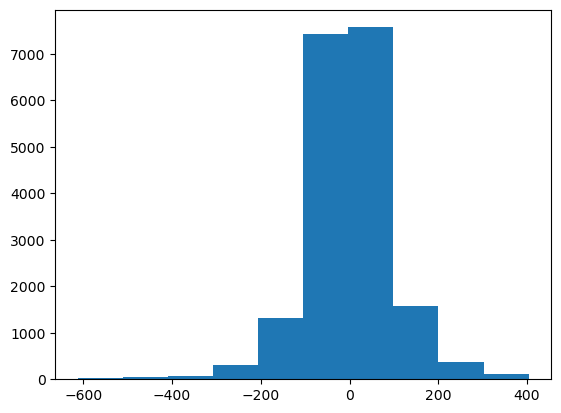

In [15]:
plt.hist((zkphat_ensemble - zkphat_ensemble.mean(axis=1, keepdims=True).repeat(nsamples, axis=1)).flatten())

array([ 71.14876701, -38.10443865,  -8.90467177, ..., -45.80413963,
         6.57832804, -24.09567057])